In [1]:
# ! pip install datasets transformers
# ! git clone https://github.com/booydar/t5-experiments/ github

In [3]:
import numpy as np
import os
import sys
import tqdm
import torch
import datasets
from matplotlib import pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
from itertools import chain
from torch.utils.data import DataLoader#, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence

# device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# sys.path.append('github')
sys.path.append('..')
device = 'cpu'

### Load model

In [4]:
model_name = 'gpt2'
model = AutoModelForCausalLM.from_pretrained(model_name)
model.to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

[2023-10-18 14:28:33,005] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [5]:
input_size = 1024
memory_size = 2
n_segments = 2

batch_size = 2

In [6]:
block_size = input_size
block_size -= 2 * memory_size
history_size = (n_segments - 1) * block_size

### Prepare dataset

In [7]:
def group_texts(examples, block_size, history_size=None):
    concatenated_examples = {k: list(chain(*examples[k])) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])

    if history_size is None:
        result = {
            k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
            for k, t in concatenated_examples.items()
        }
    else:
        result = {
            k: [t[max({0, i - history_size}) : i + block_size] for i in range(0, total_length, block_size)]
            for k, t in concatenated_examples.items()
        }
    result["labels"] = result["input_ids"].copy()
    return result

id_pad_value = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else tokenizer.eos_token_id
def collate_fn(batch):
    input_ids = [torch.tensor(b['input_ids'][::-1]) for b in batch]
    labels = [torch.tensor(b['labels'][::-1]) for b in batch]
    attention_mask = [torch.tensor(b['attention_mask'][::-1]) for b in batch]
    input_ids = pad_sequence(input_ids, padding_value=id_pad_value).T.flip(1)
    labels = pad_sequence(labels, padding_value=-100).T.flip(1)
    attention_mask = pad_sequence(attention_mask, padding_value=0).T.flip(1)

    collated = {'input_ids': input_ids,
                'labels': labels,
                'attention_mask': attention_mask}

    if input_ids.shape[1] != block_size:
        labels_mask = torch.ones_like(input_ids, dtype=bool)
        labels_mask[:, :-block_size] = False
        collated['labels_mask'] = labels_mask

    return collated

In [8]:
task_name = 'wikitext-2-v1'
raw_datasets = datasets.load_dataset('wikitext', task_name)
column_names = raw_datasets["train"].column_names
text_column_name = "text" if "text" in column_names else column_names[0]

def tokenize_function(examples):
    return tokenizer(examples[text_column_name])

tokenized_datasets = raw_datasets.map(
    tokenize_function,
    batched=True,
    remove_columns=column_names,
    desc="Running tokenizer on dataset",
)

train_dataset = tokenized_datasets["train"].map(lambda x: group_texts(x, block_size, history_size),
                                                        batched=True, desc=f"Grouping train in chunks of {block_size} and history {history_size}")
valid_dataset = tokenized_datasets["validation"].map(lambda x: group_texts(x, block_size, history_size),
                                                        batched=True, desc=f"Grouping valid in chunks of {block_size}")

In [9]:
train_rnd_generator = torch.Generator()
train_rnd_generator.manual_seed(42)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn,
                                shuffle=True, drop_last=False, generator=train_rnd_generator, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size,
                                        collate_fn=collate_fn, shuffle=False, drop_last=True, pin_memory=True)

### Create model

In [10]:
gen = iter(train_dataloader)
batch = next(gen)
batch.pop('labels_mask')
for k, v in batch.items():
    batch[k] = v.to(device)
batch['input_ids'].shape

torch.Size([2, 2040])

In [11]:
try:
    out = model(**batch)
    print('Success!')
except IndexError:
    print('Error: Input size too large!')

Error: Input size too large!


### Add RMT

In [12]:
from modeling_rmt.language_modeling import MemoryCell, RecurrentWrapper

cell = MemoryCell(model, num_mem_tokens=memory_size)
model = RecurrentWrapper(cell,
                        segment_size=block_size,
                        max_n_segments=n_segments,
                        )
model.to(device)

RecurrentWrapper(
  (memory_cell): MemoryCell(
    (model): GPT2LMHeadModel(
      (transformer): GPT2Model(
        (wte): Embedding(50257, 768)
        (wpe): Embedding(1024, 768)
        (drop): Dropout(p=0.1, inplace=False)
        (h): ModuleList(
          (0-11): 12 x GPT2Block(
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (attn): GPT2Attention(
              (c_attn): Conv1D()
              (c_proj): Conv1D()
              (attn_dropout): Dropout(p=0.1, inplace=False)
              (resid_dropout): Dropout(p=0.1, inplace=False)
            )
            (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): GPT2MLP(
              (c_fc): Conv1D()
              (c_proj): Conv1D()
              (act): NewGELUActivation()
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
        )
        (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      )
      (lm_head): Linear(in_

In [13]:
try:
    out = model(**batch)
    print('Success!')
except IndexError:
    print('Error: Input size too large!')

Success!


### Train the model

In [14]:
from torch.optim import AdamW
optim = AdamW(params=model.parameters(), lr=1e-04)

In [15]:
train_steps = 100
eval_steps = 100

train_gen = iter(train_dataloader)
valid_gen = iter(valid_dataloader)

In [16]:
losses = []
for step in tqdm.notebook.tqdm(range(train_steps)):
    optim.zero_grad()

    batch = next(train_gen)
    for k, v in batch.items():
        batch[k] = v.to(device)

    out = model(**batch)
    loss = out.loss

    loss.backward()
    optim.step()

    losses.append(loss.detach().item())

  0%|          | 0/100 [00:00<?, ?it/s]

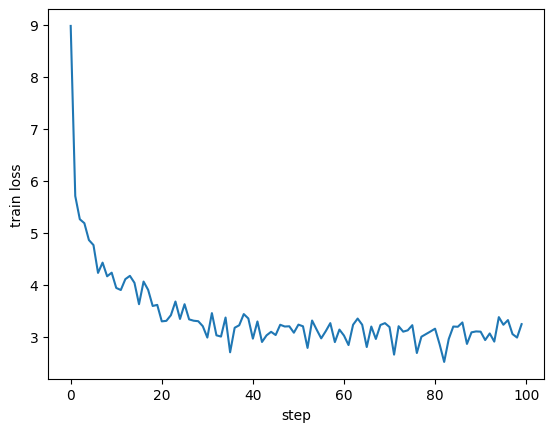

In [20]:
plt.plot(losses)
plt.xlabel('step')
plt.ylabel('train loss')
plt.show()

In [18]:
valid_losses = []
model.eval()
for step in tqdm.notebook.tqdm(range(eval_steps)):
    batch = next(valid_gen)
    for k, v in batch.items():
        batch[k] = v.to(device)

    with torch.no_grad():
        out = model(**batch)
    valid_loss = out.loss

    valid_losses.append(loss.detach().item())

  0%|          | 0/100 [00:00<?, ?it/s]

In [19]:
print(f'Loss on {eval_steps * batch_size} validation samples: {np.mean(valid_losses)}')

Loss on 200 validation samples: 3.2462313175201416
